In [160]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

from mplsetup import rcsetup
rcsetup()
rcsetup()

In [161]:
import sys
sys.path.insert(0, '/more-is-better')
from exptdetails import ExptDetails
from utils import int_logspace

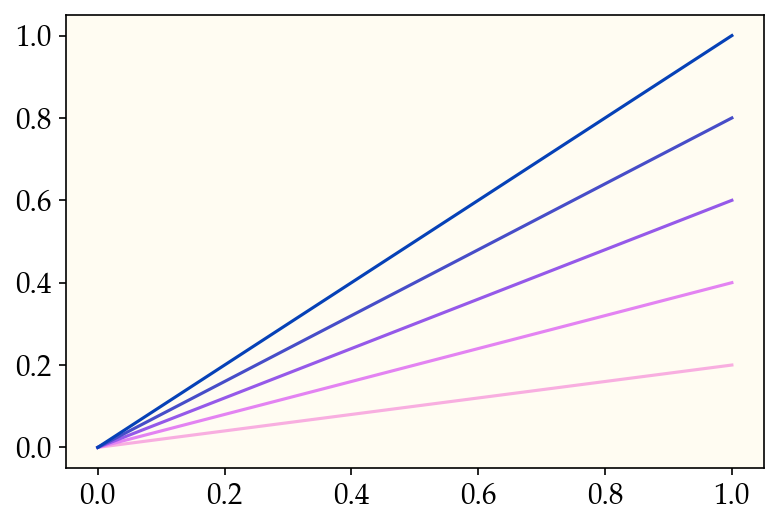

In [245]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# https://colordesigner.io/gradient-generator

def get_color(i, palnum=3):
    colors = {
        0: [
            "xkcd:pastel pink",
            "xkcd:bubblegum pink",
            "xkcd:purplish pink",
            "xkcd:bluish purple",
            "xkcd:ultramarine",],
        1: [
            "#86d4f8",
            "#478fe8",
            "#2544bb",
            "#222071",
            "#1a1230",],
        2: [
            "#f8c3e7",
            "#e578d5",
            "#c439c7",
            "#672d74",
            "#25172d",],
        3: [
            "#f1c361",
            "#e59231",
            "#bd5e1f",
            "#85361b",
            "#511b14",
        ],
        3: [
            "#f8aee0",
            "#e383f2",
            "#9559e9",
            "#474dc8",
            "#0641b7",
        ]
    }
    return colors[palnum][i%5]

x = np.linspace(0, 1)
for i in range(5):
    plt.plot(x, (1+i)/5 * x, color=get_color(i, 3))
plt.show()

In [333]:
DATASET_NAME = 'cifar10'
EXPT_NUM = 0
DEPTH = 10

expt = ExptDetails(EXPT_NUM, DEPTH, DATASET_NAME)
work_dir = f"results/{DATASET_NAME}/{expt.expt_name}"
with open(f"{work_dir}/eigdata.file", 'rb') as handle:
    eigdata = pickle.load(handle)
with open(f"{work_dir}/eigstats.file", 'rb') as handle:
    eigstats = pickle.load(handle)
with open(f"{work_dir}/optridge.file", 'rb') as handle:
    optridge = pickle.load(handle)

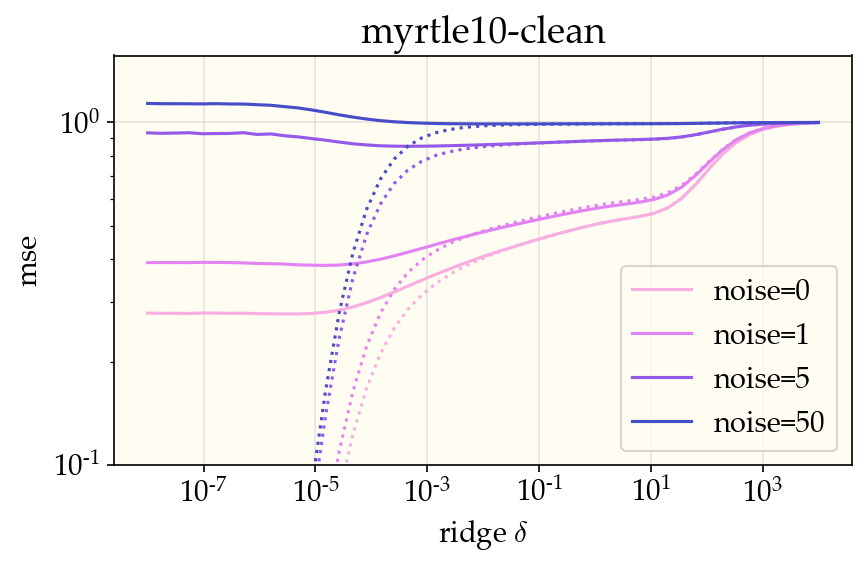

In [331]:
ax = plt.gca()

color = get_color(0)
ridges = optridge["ridges"]
noises = optridge["noise_rels"]
test_mses = optridge["test_mses"]
train_mses = optridge["train_mses"]

for i, noise in enumerate(noises):
    test_mse, train_mse = test_mses[noise], train_mses[noise]
    test_mse += 1 - test_mse[-1]
    train_mse += 1 - train_mse[-1]

    ax.plot(ridges, test_mse, color=get_color(i), label=f"noise={noise}")
    ax.plot(ridges, train_mse, ls=':', color=get_color(i))

ax.set_title(f"{expt.expt_name}")
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('ridge $\\delta$')
ax.set_ylabel('mse')
ax.set_ylim(1e-1)
plt.legend()
plt.tight_layout()
plt.grid(alpha=0.3)
plt.show()

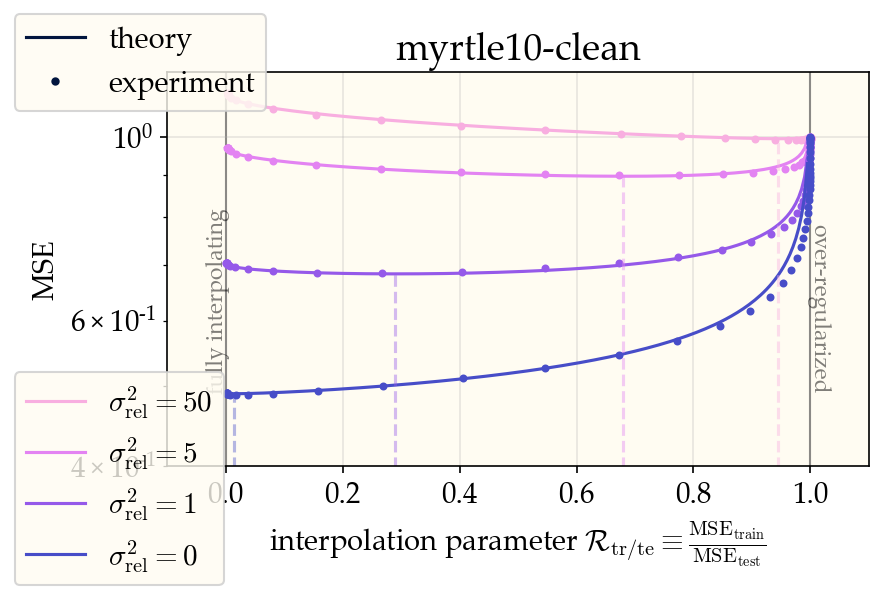

In [340]:
ax = plt.gca()

def mse_theory(R, a, b, noise, n):
    R2 = np.sqrt(R)
    pi = np.pi
    err = 1
    err *= pi**b * (a-b+1) * np.sin(pi/a) * (1/np.sin(pi*(b-1)/a))
    err *= (1 - R2 + a*noise*((1-R2)**b)) / (1 + (a-1)*R2)
    err *= (a * np.sin(pi/a) * (1-R2))**(-b)
    err *= n**(-(b-1))
    return err

color = get_color(0)
ridges = optridge["ridges"]
noises = optridge["noise_rels"]
test_mses = optridge["test_mses"]
train_mses = optridge["train_mses"]

for i, noise in enumerate(noises[::-1]):
    test_mse, train_mse = test_mses[noise], train_mses[noise]
    R = train_mse/test_mse
    
    a = 1.15
    b = 1.13
    R_thry = np.linspace(0, 1, 200, endpoint=False)
    thry = mse_theory(R_thry, a, b, noise, 30000)
    pf = test_mse[0]/thry[0]
    thry *= pf
    ax.plot(R_thry, thry, color=get_color(i), label=f"$\sigma^2_\mathrm{{rel}}={noise}$", zorder=1)
    
    ax.scatter(R, test_mse, s=8, color=get_color(i), zorder=1)
    minidx = thry.argmin()
    ax.vlines(R_thry[minidx], 0, thry[minidx], ls='--', alpha=0.4, color=get_color(i))
    # ax.plot(ridges, train_mse, ls=':', color=get_color(i))

ax.vlines(0, 0, 1.5, color='k', lw=1, alpha=0.5, zorder=-4)
ax.vlines(1, 0, 1.5, color='k', lw=1, alpha=0.5, zorder=-4)
ax.set_title(f"{expt.expt_name}")
ax.text(0.007, 0.5, "fully interpolating", rotation=90, ha='right', size=11, alpha=0.5)
ax.text(.993, 0.5, "over-regularized", rotation=-90, ha='left', size=11, alpha=0.5)
# ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('interpolation parameter $\mathcal{R}_\mathrm{tr/te}\equiv\\frac{\mathrm{MSE}_\mathrm{train}}{\mathrm{MSE}_\mathrm{test}}}$')
ax.set_ylabel('MSE')
ax.set_ylim(0.4, 1.2)
ax.set_xlim(-.1, 1.1)
noise_legend = plt.figlegend(loc='lower left',)
plt.figlegend(
        (
            Line2D([0], [0], color='xkcd:navy'),
            Line2D([0], [0], color='xkcd:navy', ls="none", marker='.'),),
        (
            "theory",
            "experiment",),
        loc='upper left',
    )
plt.tight_layout()
ax.set_axisbelow(True)
ax.grid(alpha=0.3, zorder=-5)
plt.show()

## Powerlaw estimation

In [297]:
DATASET_NAME = 'cifar10'
EXPT_NUM = 0
DEPTH = 10

expt = ExptDetails(EXPT_NUM, DEPTH, DATASET_NAME)
work_dir = f"results-old/{expt.expt_name}"
with open(f"{work_dir}/eigdata.file", 'rb') as handle:
    eigdata = pickle.load(handle)
with open(f"{work_dir}/eigstats-old.file", 'rb') as handle:
    eigstats = pickle.load(handle)

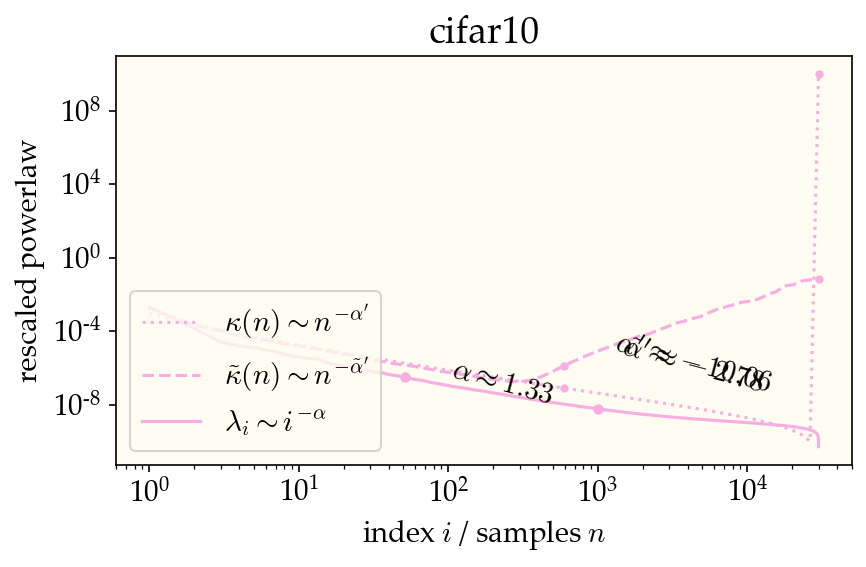

In [329]:
DATASET_NAME = 'cifar10'
EXPT_NUM = 0
DEPTH = 10

expt = ExptDetails(EXPT_NUM, DEPTH, DATASET_NAME)
work_dir = f"results/{DATASET_NAME}/{expt.expt_name}"
with open(f"{work_dir}/eigdata.file", 'rb') as handle:
    eigdata = pickle.load(handle)
with open(f"{work_dir}/eigstats.file", 'rb') as handle:
    eigstats = pickle.load(handle)
    
    ax = plt.gca()

eigvals = eigstats["eigvals"]
n = len(eigvals)
idxs = 1 + np.arange(n)

sizes = eigstats["sizes"]
f1, f2 = 1, 1 # 500, 30
all_endpts = [[50, 1000], [30, 1000], [80, 6000], [20, 300]]
rot = -15
lift = 1.6

kappas = eigstats["true_kappas"]
# kappas /= kappas.max()
kappa_estims = eigstats["kappa_estimates"]
# kappa_estims /= kappa_estims.max()
# eigvals = eigvals / eigvals[0]
color = get_color(0)
ax.plot(sizes, f1*kappas, color=color, ls=":", label="$\\kappa(n)\\sim n^{-\\alpha'}$")
ax.plot(sizes, f2*kappa_estims, color=color, ls="--", label="$\\tilde{\\kappa}(n)\\sim n^{-\\tilde{\\alpha}'}$")
ax.plot(idxs, eigvals, color=color, label="$\\lambda_i\\sim i^{-\\alpha}$")

start, end = 49, 30
endpts = [start, start+30]
x1, x2 = sizes[endpts]
y1, y2 = f2 * kappa_estims[endpts]
alpha3 = -np.log(y2/y1) / np.log(x2/x1)
ax.plot((x1, x2), (y1, y2), color=color, ls='none',
        marker='.', markersize=6)
x_mid = int(np.sqrt(x1 * x2))
y_mid = lift*f2 * kappa_estims[(start+end)//2]
ax.text(x_mid, y_mid, f"$\\tilde{{\\alpha}}'\\approx{alpha3:.2f}$",
        rotation=rot, rotation_mode="anchor", ha='center')

# start, end = 15, 25
# endpts = [start, end]
x1, x2 = sizes[endpts]
y1, y2 = f1 * kappas[endpts]
alpha2 = -np.log(y2/y1) / np.log(x2/x1)
ax.plot((x1, x2), (y1, y2), color=color, ls='none',
        marker='.', markersize=6)
x_mid = int(np.sqrt(x1 * x2))
y_mid = lift*f1 * kappas[(start+end)//2]
ax.text(x_mid, y_mid, f"${{\\alpha}}'\\approx{alpha2:.2f}$",
        rotation=rot, rotation_mode="anchor", ha='center')

endpts = all_endpts[0]
x1, x2 = idxs[endpts]
y1, y2 = eigvals[endpts]
alpha = -np.log(y2/y1) / np.log(x2/x1)
ax.plot((x1, x2), (y1, y2), color=color, ls='none',
        marker='.', markersize=8)
x_mid = int(np.sqrt(x1 * x2))
ax.text(x_mid, lift*eigvals[x_mid], f"$\\alpha\\approx{alpha:.2f}$",
        rotation=rot, rotation_mode="anchor", ha='center')


ax.legend(loc="lower left")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title(DATASET_NAME)

plt.xlabel("index $i$ / samples $n$")
plt.ylabel("rescaled powerlaw")

plt.tight_layout()
plt.show()

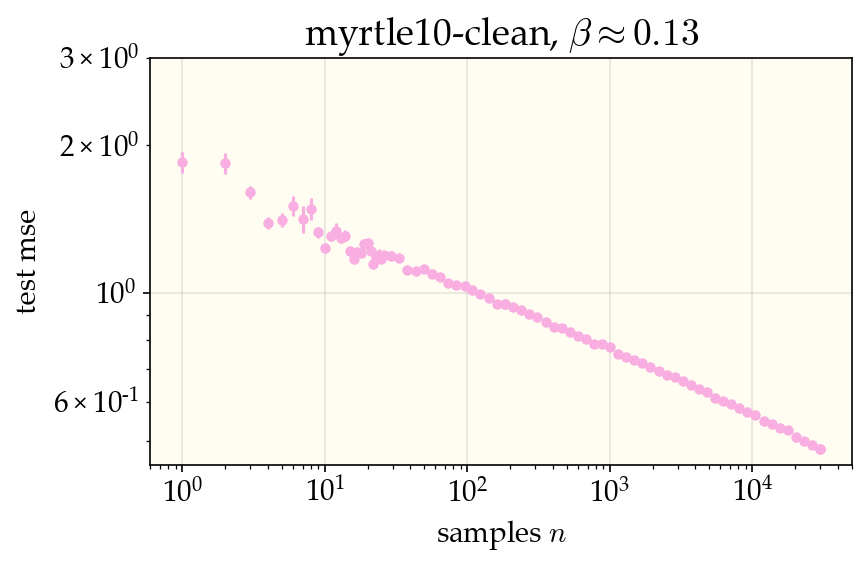

In [330]:
ax = plt.gca()

color = get_color(0)
sizes = eigstats["sizes"]
test_mses = eigstats["test_mses"]
test_mean, test_std = test_mses.mean(axis=0), test_mses.std(axis=0)
n_trials = test_mses.shape[0]

ax.errorbar(sizes, test_mean, yerr=test_std/np.sqrt(n_trials), ls='none',
            marker='o', markersize=4, color=color)

start, end = 40, len(sizes)-1
endpts = [start, end]
x1, x2 = sizes[endpts]
y1, y2 = test_mean[endpts]
beta = -np.log(y2/y1) / np.log(x2/x1)
ax.plot((x1, x2), (y1, y2), color=color, ls='none',
        marker='.', markersize=8)

ax.set_title(f"{expt.expt_name}, $\\beta\\approx{{{beta:.2f}}}$")
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('samples $n$')
ax.set_ylabel('test mse')
ax.set_ylim(top=3)
plt.tight_layout()
plt.grid(alpha=0.3)
plt.show()